In [68]:
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import shape
import json

In [69]:
csv_paths = [
    "bzm_telraam_2025_01.csv",
    "bzm_telraam_2025_02.csv",
    "bzm_telraam_2025_03.csv",
    "bzm_telraam_2025_04.csv",
    "bzm_telraam_2025_05.csv",
    "bzm_telraam_2025_06.csv"
]
dfs = [pd.read_csv(path) for path in csv_paths]

df_all = pd.concat(dfs, ignore_index=True)
df_all["date_local"] = pd.to_datetime(df_all["date_local"], errors="coerce")


In [70]:


# 2. Aggregate average traffic per segment
agg_df = df_all.groupby("segment_id")[["ped_total", "bike_total", "car_total"]].mean().reset_index()
agg_df.columns = ["segment_id", "avg_pedestrians", "avg_bikes", "avg_cars"]



In [71]:
# 3. Load and parse GeoJSON
with open("bzm_telraam_segments.geojson", "r") as f:
    gj = json.load(f)

# Extract segment IDs and geometries
geoms = []
seg_ids = []
for feature in gj["features"]:
    seg_ids.append(feature["properties"]["segment_id"])
    geoms.append(shape(feature["geometry"]))

In [72]:
# 4. Create GeoDataFrame
gdf = gpd.GeoDataFrame({"segment_id": seg_ids}, geometry=geoms, crs="EPSG:4326")


In [73]:
# 5. Merge with aggregated traffic data
merged_gdf = gdf.merge(agg_df, on="segment_id")

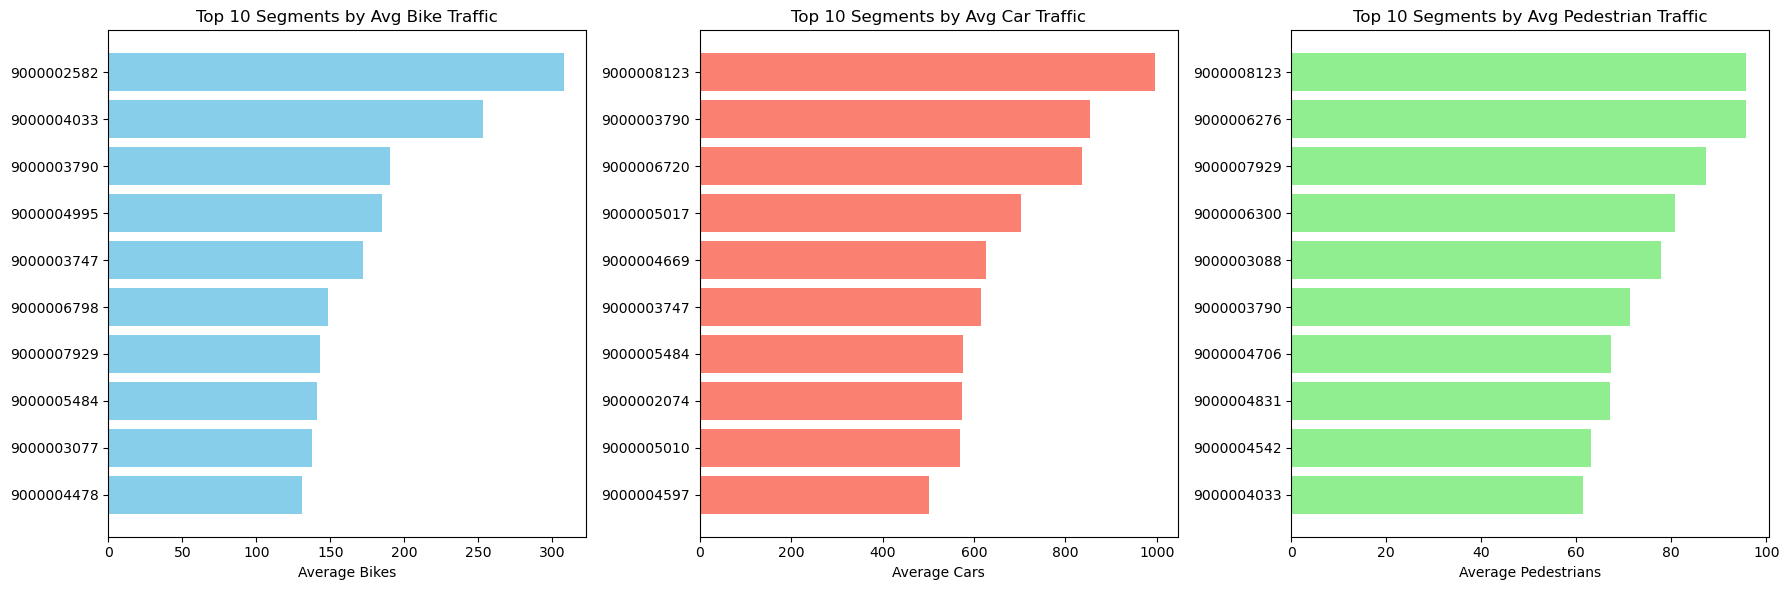

In [74]:
import matplotlib.pyplot as plt

# Top 10 segments by traffic type
top_bike = merged_gdf[["segment_id", "avg_bikes"]].sort_values(by="avg_bikes", ascending=False).head(10)
top_car = merged_gdf[["segment_id", "avg_cars"]].sort_values(by="avg_cars", ascending=False).head(10)
top_ped = merged_gdf[["segment_id", "avg_pedestrians"]].sort_values(by="avg_pedestrians", ascending=False).head(10)

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bikes
axes[0].barh(top_bike["segment_id"].astype(str), top_bike["avg_bikes"], color="skyblue")
axes[0].set_title("Top 10 Segments by Avg Bike Traffic")
axes[0].set_xlabel("Average Bikes")
axes[0].invert_yaxis()

# Cars
axes[1].barh(top_car["segment_id"].astype(str), top_car["avg_cars"], color="salmon")
axes[1].set_title("Top 10 Segments by Avg Car Traffic")
axes[1].set_xlabel("Average Cars")
axes[1].invert_yaxis()

# Pedestrians
axes[2].barh(top_ped["segment_id"].astype(str), top_ped["avg_pedestrians"], color="lightgreen")
axes[2].set_title("Top 10 Segments by Avg Pedestrian Traffic")
axes[2].set_xlabel("Average Pedestrians")
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()


In [75]:
# 6. Compute centroids
projected = merged_gdf.to_crs(epsg=32633)
centroids = projected.centroid.to_crs(epsg=4326)
merged_gdf["lon"] = centroids.x
merged_gdf["lat"] = centroids.y


In [76]:
# 7. Build Folium map
m = folium.Map(location=[52.52, 13.405], zoom_start=12, tiles="cartodb dark_matter")
tooltip = folium.GeoJsonTooltip(
    fields=["segment_id", "avg_bikes", "avg_pedestrians", "avg_cars"],
    aliases=["Segment", "Bikes", "Pedestrians", "Cars"],
    sticky=True
)
folium.GeoJson(
    merged_gdf,
    name="Berlin Traffic Segments",
    style_function=lambda x: {"color": "cyan", "weight": 2},
    tooltip=tooltip
).add_to(m)

In [77]:
# 8. Save map to HTML
m.save("berlin_traffic_map_final.html")



In [78]:
m